### Preprocessing

In [1]:
import numpy as np
import pandas as pd
import glob
import os

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk

import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
#nltk.download('stopwords')
#from sklearn.feature_extraction.text import CountVectorizer
import en_core_web_sm


import re

from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.model_selection import train_test_split

import warnings

import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/data.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/distances.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/hott.py'
%run '/Users/Hugo/Documents/Github/HOTT_NLP_ENSAE/knn_classifier.py'

#### On load le dataframe sur lequel on travaille (ici on prend un tout petit subsample)

In [2]:
data_dir = '/Users/Hugo/Documents/Cours/ENSAE/3A/S2/NLP/Projet/data/nyt-comments'
#embed_path_300 = '/Users/Hugo/Documents/Cours/ENSAE/3A/S2/NLP/Projet/data/glove.6B/glove.6B.300d.txt'
embed_path_50 = '/Users/Hugo/Documents/Cours/ENSAE/3A/S2/NLP/Projet/data/glove.6B/glove.6B.50d.txt'
df_ = pd.read_csv(glob.glob(data_dir+'/Comments*.csv')[0], encoding = 'latin1')
df_ = df_.sample(frac=1).reset_index(drop=True)
#cols = df_.columns
df_test = df_[0:1000].reset_index(drop = True)
#del df_

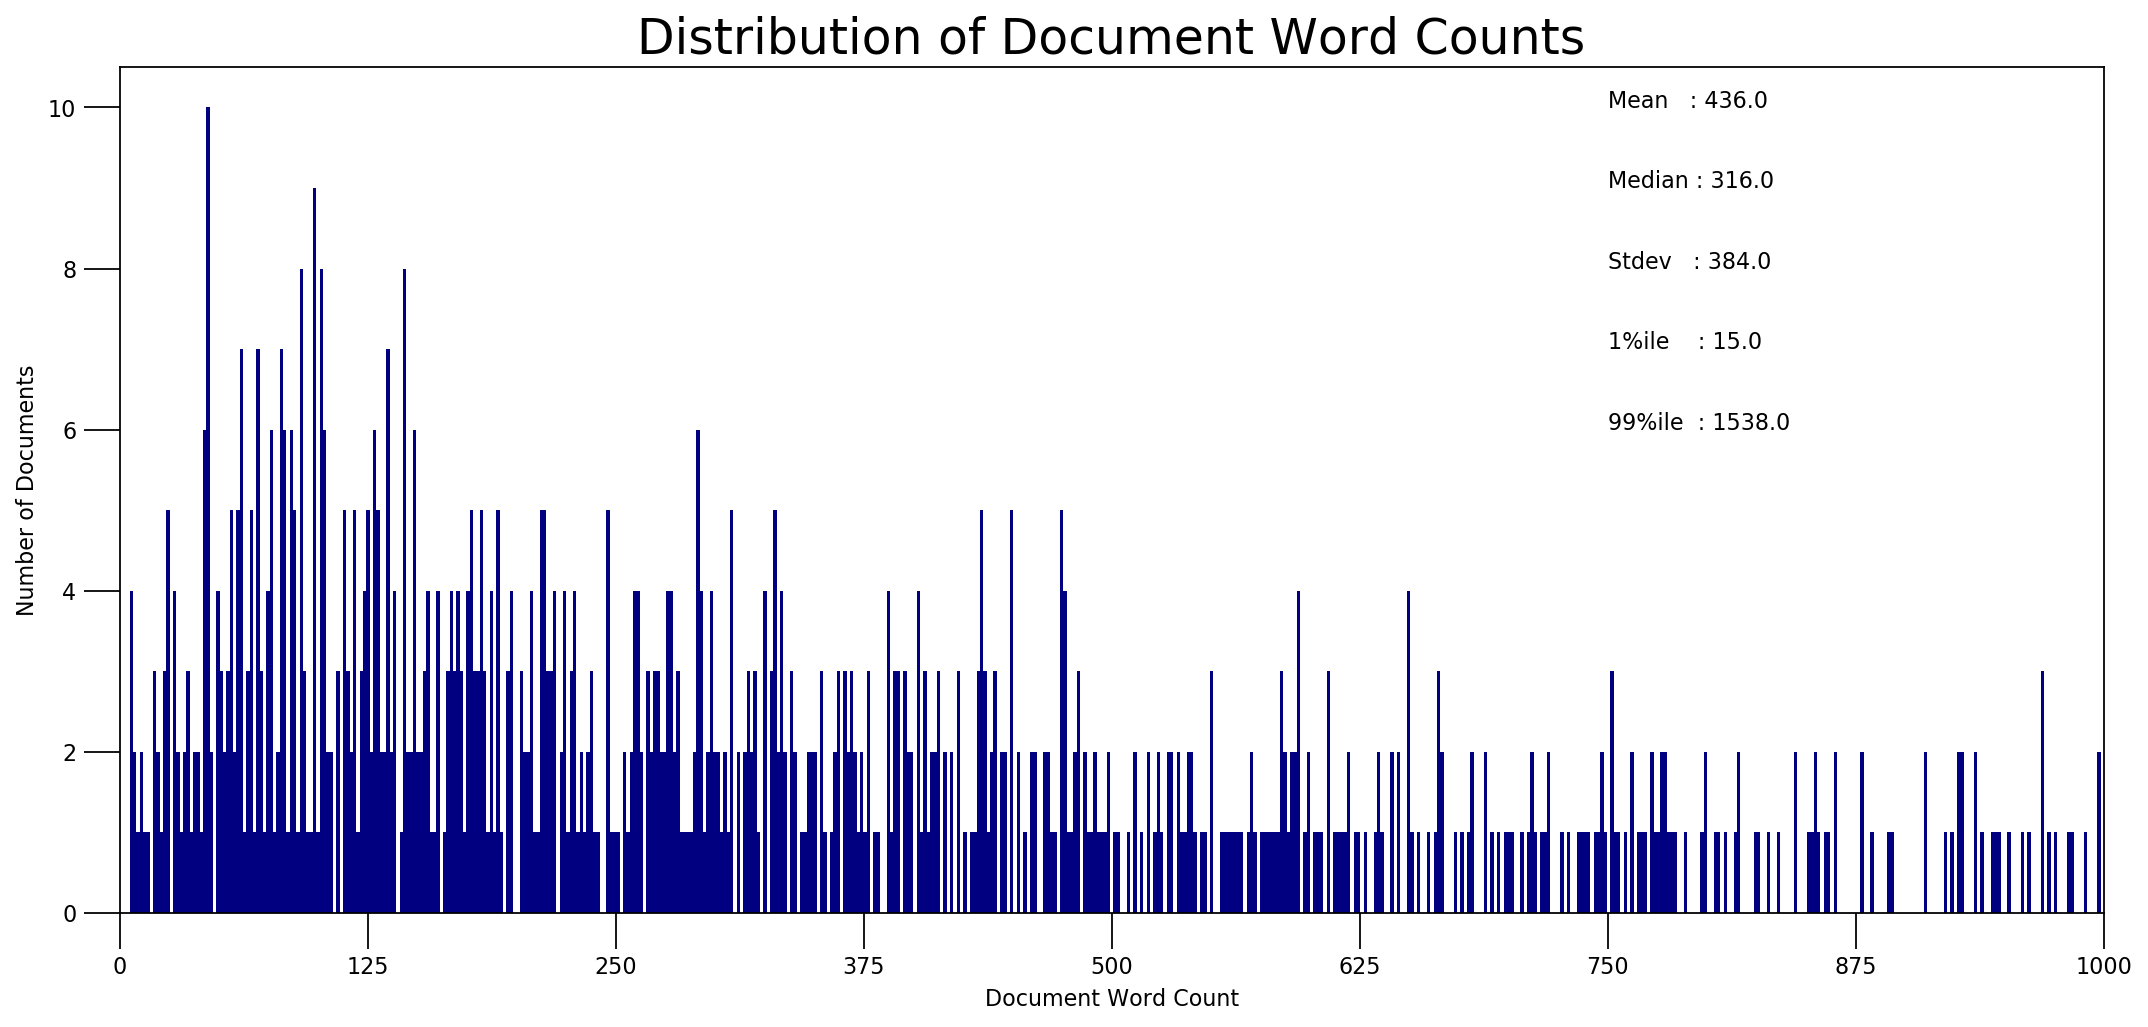

In [3]:
# Heuristics on the documents before stemming

doc_lens = [len(d) for d in df_test.commentBody]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 10, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  9, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [4]:
# hyperparameters
k = 10
stemming_ = True 
p_ = 1
n_word_keep_ = 20

# dataloading
data = load_data(df_test, embed_path_50, stemming = stemming_, K = k, p = p_, n_word_keep = n_word_keep_)

The vocabulary has been reduced from 9258 words to 3388 words.
LDA Gibbs topics
Topic 0: trump presid tax like one would us obama countri make peopl war korea money north go thing cut time help
Topic 1: us republican parti get mani trump go world work democrat know presid support nation like vote mr unit bad come
Topic 2: would tax peopl time pay year cost much work long could dont think make interest plan even money pain like
Topic 3: trump go pay could would peopl new use tax dont contract make news state also govern social money media play
Topic 4: one us think get need would never peopl work time go dont could realli make take even come know way
Topic 5: trump like peopl think dont make time see call made use posit would want us enough get logic support action
Topic 6: tax trump like democrat need make peopl return state would may good white year know thank everi vote work voter
Topic 7: trump right one clinton republican court elect vote countri polit would senat democrat obama pr

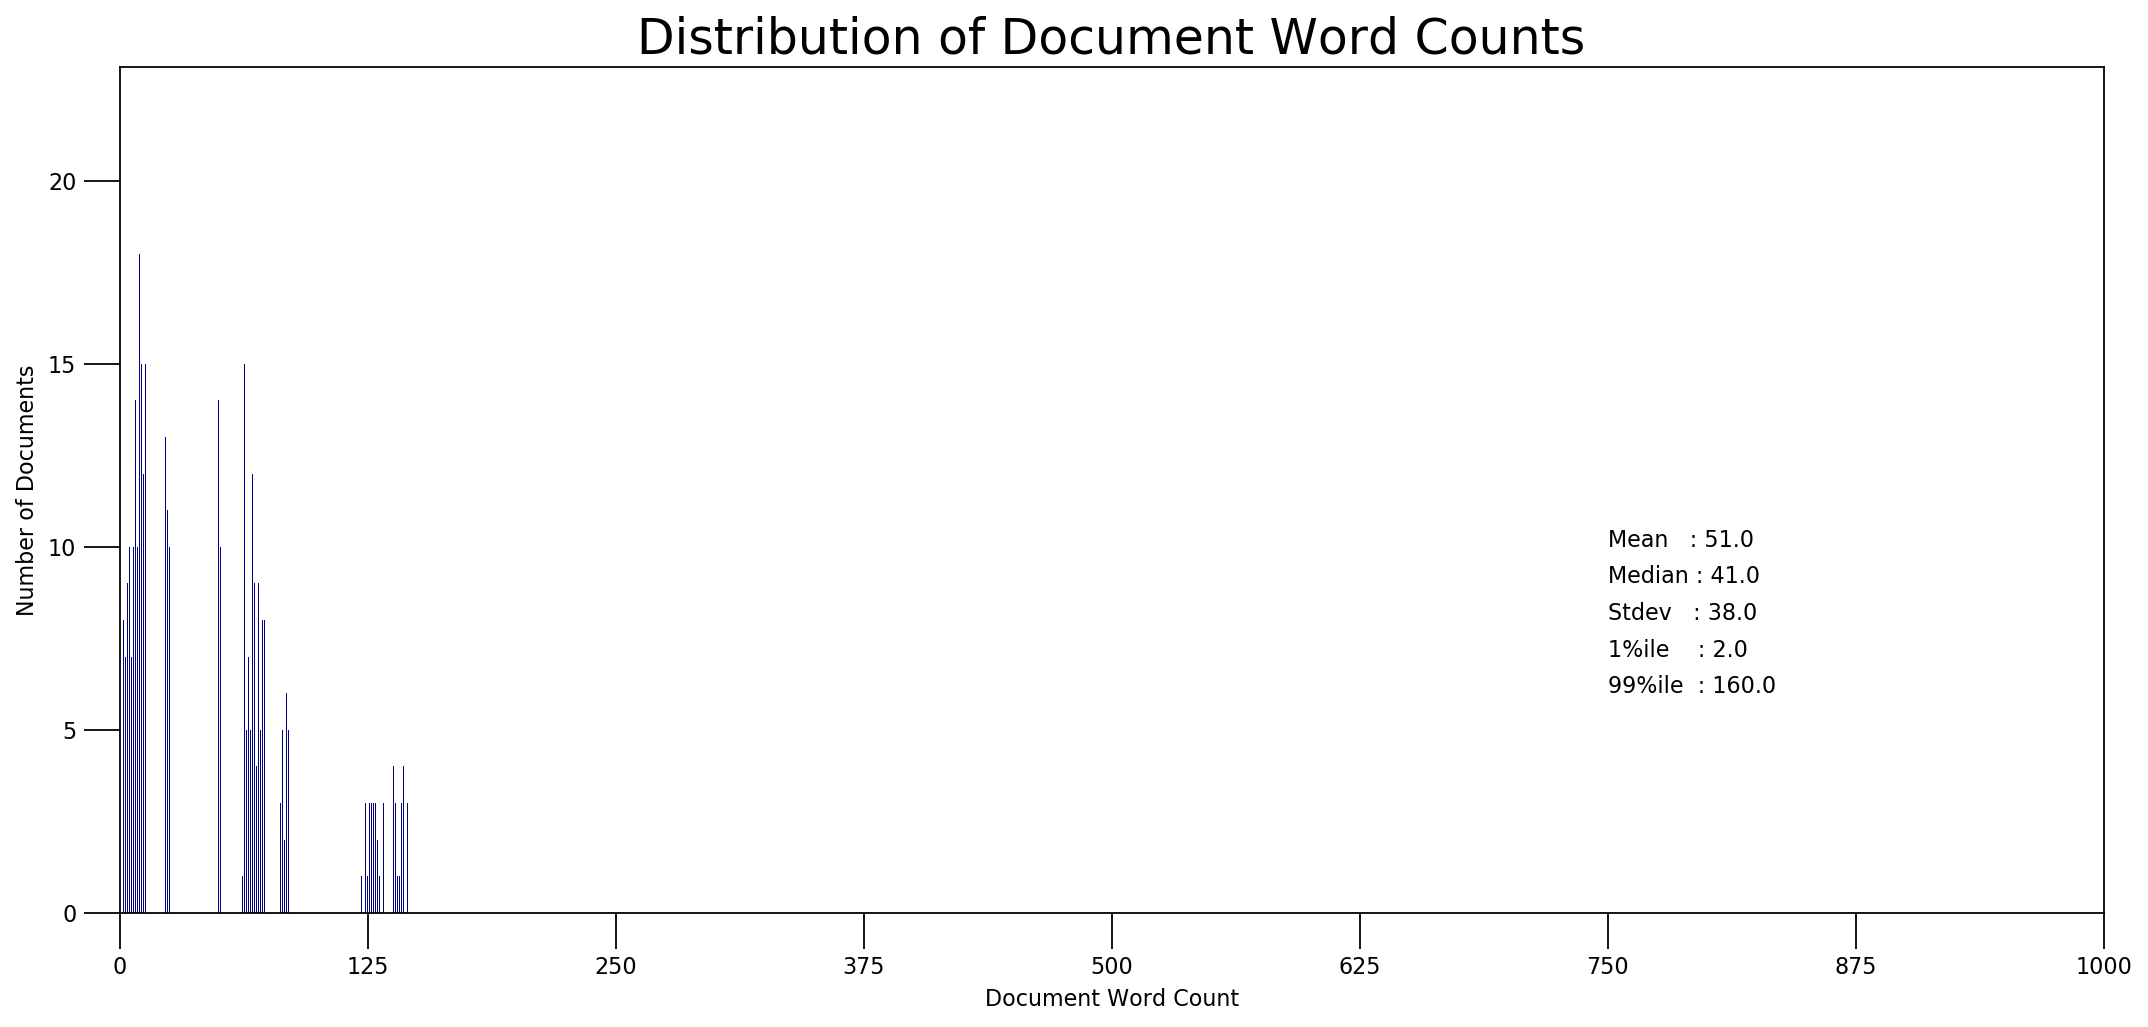

In [5]:
# Heuristics on the documents before stemming

doc_lens = [len(d) for d in data['text']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 10, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  9, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [6]:
voc, y = transform_dataframe(df_test)
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(data['proportions']):
    max_proportion = np.amax(row_list)
    idx_max_topic = np.where(row_list == max_proportion)[0][0]
    sent_topics_df = sent_topics_df.append(pd.Series([int(idx_max_topic), round(max_proportion,4), data['topic_words'][idx_max_topic]]), ignore_index=True)

sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df["Representative Text"] = voc
del voc, y

sent_topics_df.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Representative Text
0,4.0,0.6603,"[one, us, think, get, need, would, never, peop...","[the, populism, explanation, is, mostly, a, co..."
1,8.0,0.9719,"[trump, peopl, like, say, get, need, make, use...","[1, toto, i, dont, think, this, is, kansas2, h..."
2,5.0,0.9500,"[trump, like, peopl, think, dont, make, time, ...","[america, took, a, giant, step, backward, elec..."
3,2.0,0.4231,"[would, tax, peopl, time, pay, year, cost, muc...","[stop, your, compassion, is, overwhelming, me]"
4,5.0,0.9182,"[trump, like, peopl, think, dont, make, time, ...","[bold, is, not, the, correct, adjective, for, ..."
5,0.0,0.9182,"[trump, presid, tax, like, one, would, us, oba...","[81, percent, of, selfidentifying, christian, ..."
6,5.0,0.9400,"[trump, like, peopl, think, dont, make, time, ...","[i, made, an, indictment, of, our, shared, cou..."
7,0.0,0.8714,"[trump, presid, tax, like, one, would, us, oba...","[i, wholeheartedly, agree, and, i, place, my, ..."
8,7.0,0.9836,"[trump, right, one, clinton, republican, court...","[when, the, chapter, is, written, on, this, pe..."
9,1.0,0.9437,"[us, republican, parti, get, mani, trump, go, ...","[this, travel, monopolyoligopoly, and, horrend..."


In [7]:
# Most representative sentence of each topic

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = sent_topics_df.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9923,"[trump, presid, tax, like, one, would, us, oba...","[if, trump, succeeds, forcing, through, his, â..."
1,1.0,0.9924,"[us, republican, parti, get, mani, trump, go, ...","[i, was, one, of, those, lefties, left, behind..."
2,2.0,0.9931,"[would, tax, peopl, time, pay, year, cost, muc...","[darren, daulton, catcher, for, the, 1993, pen..."
3,3.0,0.9926,"[trump, go, pay, could, would, peopl, new, use...","[jane, addams, like, eleanor, and, franklin, r..."
4,4.0,0.9929,"[one, us, think, get, need, would, never, peop...","[even, in, jobs, office, workers, would, never..."
5,5.0,0.9930,"[trump, like, peopl, think, dont, make, time, ...","[rep, tulsi, gabbard, of, hawaii, recommended,..."
6,6.0,0.9927,"[tax, trump, like, democrat, need, make, peopl...","[not, only, is, democratic, turnout, up, in, t..."
7,7.0,0.9926,"[trump, right, one, clinton, republican, court...","[this, piece, misses, the, mark, masquerading,..."
8,8.0,0.9921,"[trump, peopl, like, say, get, need, make, use...","[russia, has, said, all, along, stop, the, jih..."
9,9.0,0.9928,"[peopl, trump, would, like, mani, job, year, c...","[for, all, the, naysayers, out, there, complai..."


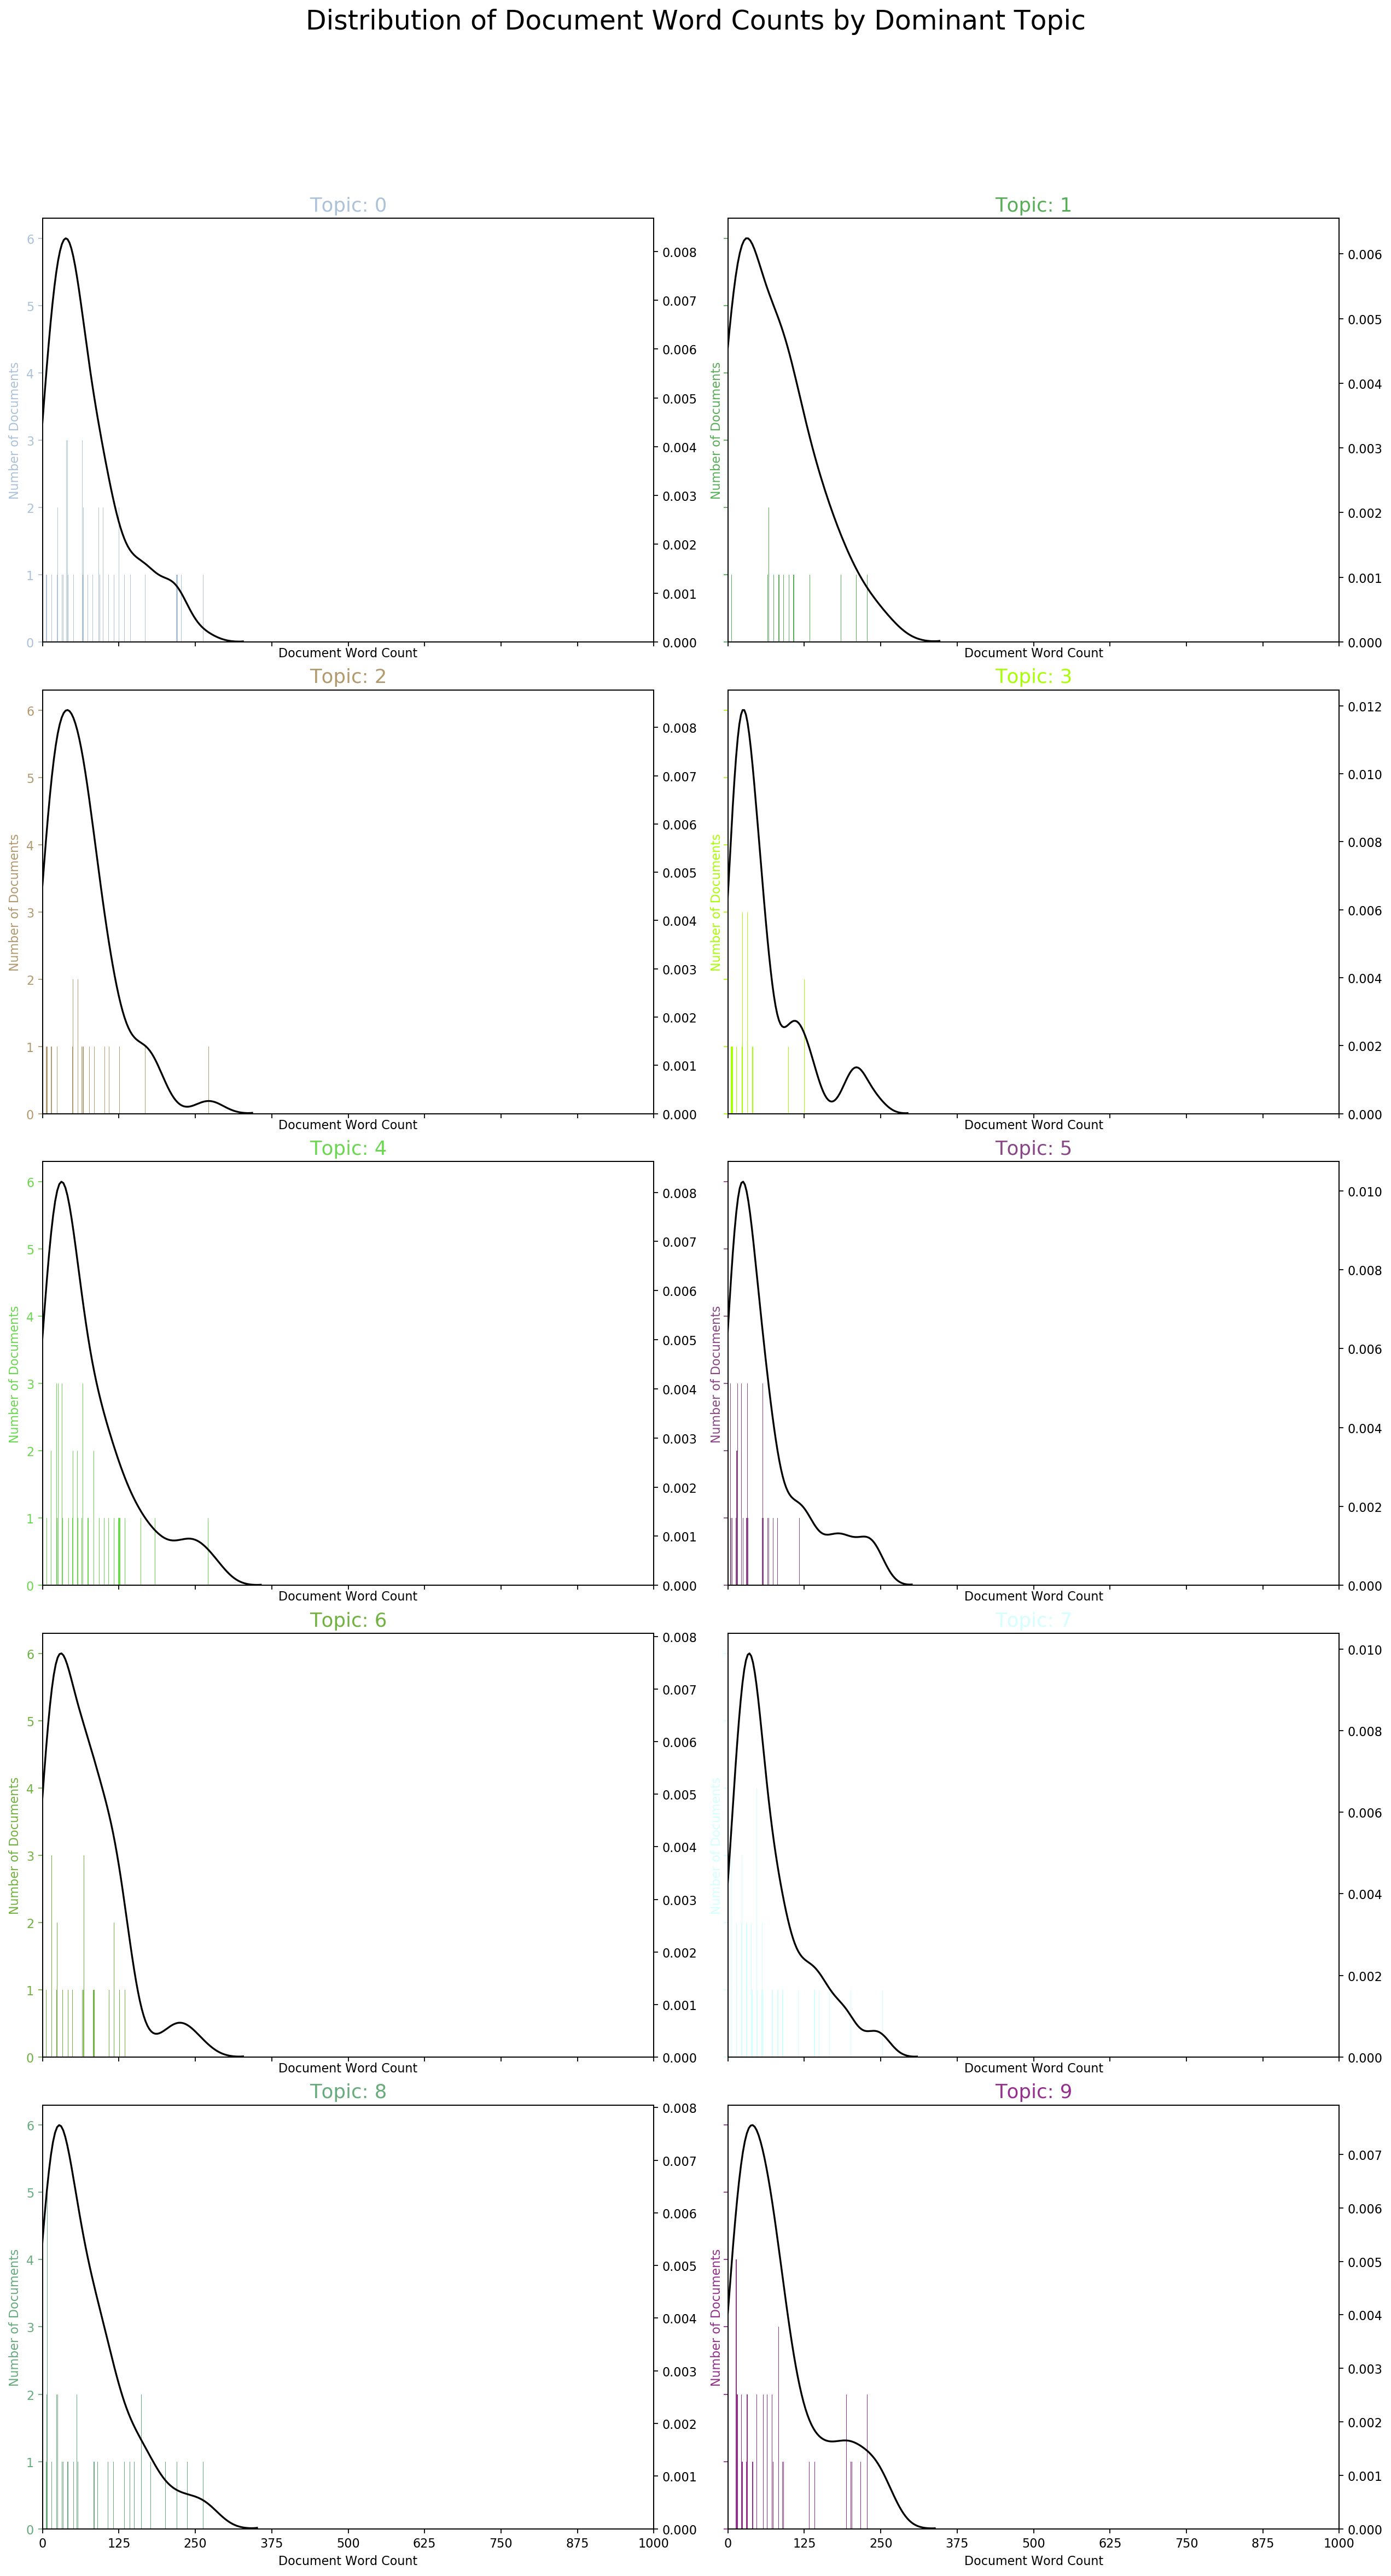

In [8]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,30), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = sent_topics_df.loc[sent_topics_df.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub['Representative Text']]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Revoir la fonction qui enlève les stops words car elle ne semble pas fonctionner : pourrait expliquer les mauvaises perf

In [9]:
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(data['X'],
                                                                                 data['proportions'],
                                                                                 data['y'],
                                                                                 random_state= 0)

In [10]:
C = data['cost_T']
n_classes = len(np.unique(y_train))

In [11]:
np.unique(y_train)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 18, 19, 20, 21, 22, 23])

In [12]:
# We could test with wmd and other distances in the file distances.py, however, the computational time may limit us
for neigh in {7,9,11,13,18} :
    hott_test_error, hott_pred = knn(topic_train, topic_test, y_train, y_test, hott, C, n_neighbors=neigh)
    print('Pour un un nombre de voisin égal à %s l\'erreur sur la base de test est de l\'ordre de %s'%(neigh,hott_test_error))

Pour un un nombre de voisin égal à 7 l'erreur sur la base de test est de l'ordre de 0.748
Pour un un nombre de voisin égal à 9 l'erreur sur la base de test est de l'ordre de 0.736
Pour un un nombre de voisin égal à 11 l'erreur sur la base de test est de l'ordre de 0.732
Pour un un nombre de voisin égal à 13 l'erreur sur la base de test est de l'ordre de 0.72
Pour un un nombre de voisin égal à 18 l'erreur sur la base de test est de l'ordre de 0.6799999999999999


In [13]:
def cust_hott(p,q):
    
    return hott(p, q, C, threshold=None)

In [16]:
D = {}

for id1,doc1 in enumerate(data['proportions']):
    D[id1] = {}
    for id2,doc2 in enumerate(data['proportions']):
        D[id1][id2] = hott(doc1, doc2, C, threshold=None)
        
hott_mat = pd.DataFrame.from_dict(D)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


In [18]:
colors = {}
for y_ in np.unique(data['y']) :
    colors[y_] = cols[y_+3]

<Figure size 432x288 with 0 Axes>

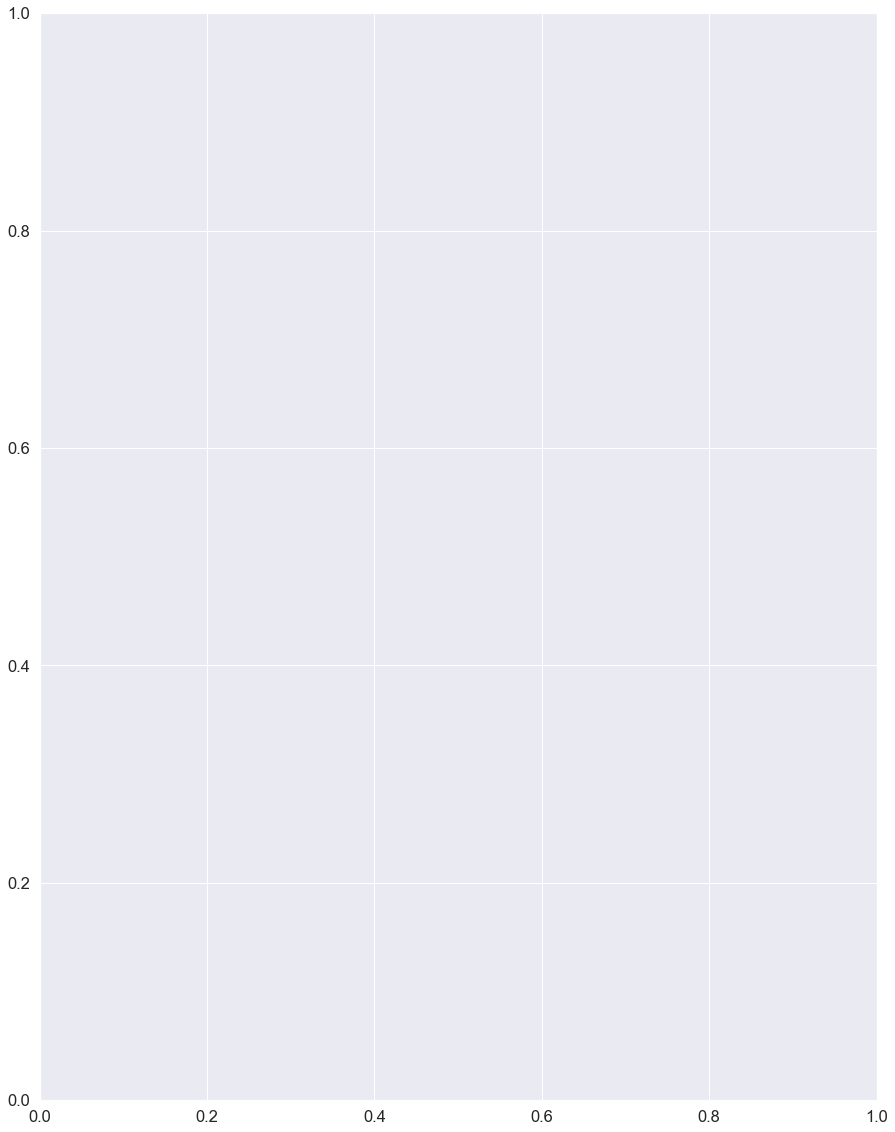

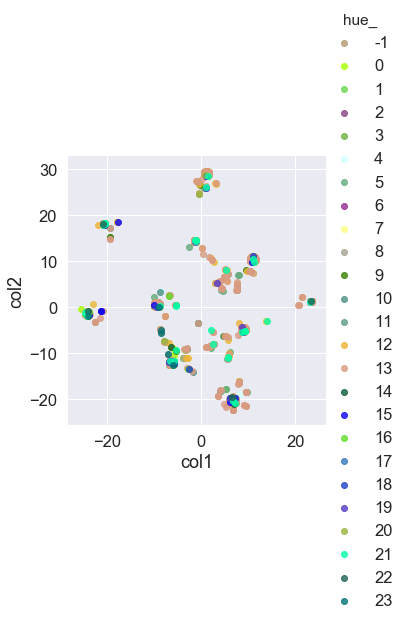

In [29]:
from sklearn.manifold import TSNE 

Xtsne = pd.DataFrame(TSNE(n_components=2, metric = cust_hott).fit_transform(data['proportions']), columns = ['col1','col2'])
Xtsne['hue_'] = data['y']

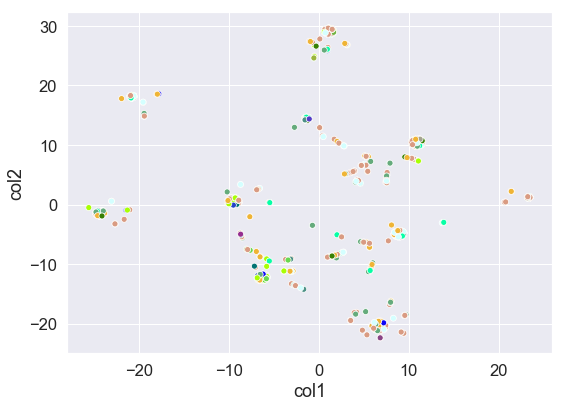

In [42]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(8.7, 6.27)
a = sns.scatterplot('col1','col2', data = Xtsne, hue = 'hue_', palette = colors, legend = False)